# Calculs thermiques du fermenteur cylindro-conique

## Methode

La simulation présente as pour but de calculer les performances du système de refroidissement peltier. La simulation est effectué dans le régime transitoire afin d'optimiser les temps de réponses dans le futur. Voici l'équation primaire de la simulation.

$\frac{q_{conv}-q_{plt}}{C_{p_th}}*dt = dT(t)$

où :    

$t$ = temps (s)

$T$ = Température (°C)

$q_{conv}$ = Puissance de convection du fermenteur (W)

$q_{plt}$  = Puissance net de conduction du peltier (W)

$C_{p_th}$ = Capacité thermique de la bière (J/°C)


## Modules

In [148]:
import numpy as np
import scipy as sp
import scipy.constants as const
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import pylab
import sys
import plotly
from plotly.offline import plot

## Paramètres

### Environnement

In [149]:
# Température de la pièce
T_ambiant = 20 # °C

### Cylindro-conique

#### Donées indépendantes

In [150]:
V_conical_g = 7 #gallons

diametre = 11.8 #po
hauteur_cyl = 10 #po
hauteur_total = 24 #po

epaisseur_ss = 0.0478 #po. (18 gauge)
epaisseur_neo = 0.006 #m

#### Données dépendantes

In [151]:
# Gallon to m³
V_conical_l = 3.78541 * V_conical_g # Litres
V_conical = V_conical_l * 0.001 #m³

# Inches to m
dia_cyl = (diametre*2.54)/100 #m
h_cyl = (hauteur_cyl * 2.54)/100 #m
h_tot = (hauteur_total*2.54)/100 #m

# Cone
h_cone = h_tot-h_cyl #m
l_cone = np.sqrt((dia_cyl/2)**2+h_cone**2) #m
air_cone = np.pi * (dia_cyl/2) * l_cone #m²

# Cylindre
air_cyl = np.pi * (dia_cyl/2)**2 * h_cyl #m²

# Couvercle
air_lid = np.pi * (dia_cyl/2)**2

# Total
air_tot = air_cyl + air_cone + air_lid #m²
print('Aire du conical = ',air_tot,'m²')


# Vérification des dimensions vs volume
V_cone = (1/3 * np.pi * (dia_cyl/2)**2) * h_cone #m³
V_cyl = np.pi * (dia_cyl/2)**2 * h_cyl #m³
V_verif = (V_cone + V_cyl) #m³
V_conical_verif = (V_verif)*264.17 #gallons
Diff_vol_verif = V_conical_verif - V_conical_g


print('La différence entre les dimensions et le volume net = ',Diff_vol_verif)

Aire du conical =  0.270150262955 m²
La différence entre les dimensions et le volume net =  -0.0566355136276373


### Bière
#### Données indépendantes

In [152]:
T_biere_goal = 12 # °C (Température désiré de fermentation)
T_wort = 35 # °C (Température de la bière avant la mise en marche du système)
V_biere_l = 19 #Litres
OG = 1.050 #g/cm³
cp_th =4.186 # kJ/(kg*°C) 



#### Données dépendantes

In [153]:
V_biere = V_biere_l * 0.001 # m³
rho_b = OG * 1000 #Kg/m³
m_b = rho_b * V_m3 #kg
Cp_th = (cp_th * m_b)*1000 #J/°C

### Système de redroidissement

#### Données indépendantes

In [154]:
# Cellules Peltiers
nb_plt = 2 # Nombre de cellules
q_plt_ch = 45.5 # W
air_plt_ch = 0.04 * 0.04 # m²

# Heat sink
epaisseur_hs = 0.01 #m (à déterminer)
air_hs = 0.08*0.08 #m² (à déterminer)

# Plaque de contact
air_plq = 0.0065 # m²
epaisseur_plq = 0.0075 # m² à (déterminer)



#### Données dépendantes

## Calculs thermiques

### Transfert de chaleur de l'air ambiant vers la bière.

Ce transfert thermique se trouve à être la partie passive entre la bière et l'environement. Il sera donné comme hypothèse que la température de l'air ambiant (chaud) se transfert vers la bière (froid), afin de représenter $q_{in}$ de notre équation primaire. Cette partie regroupe les éléments suivants,

* La conduction dans l'acier inox du conical
* La résistance thermique de contacte entre l'acier inox et le néoprène
* La conduction dans le néoprène
* La convection naturelle du néoprène vers l'air ambiant

Tous ces éléments peuvent être combiné en série afin de calculer une résistance équivalente totale. Cette résistance équivalente sera utilisé dans le calcul de la quantité du transfert thermique en fonction du temps.  

$ q_{in}(t) = \dfrac{\Delta T(t)}{R_{eqv}}      $

où,

$q_{in}(t)$ = le flux thermique (W) en fonction du temps (s)

$\Delta T(t)$ = La différence de température (°C) entre l'air ambiant et la bière. La température ambiante restera constante (hypothèse).


#### Calcul de la résistance équivalente de conduction passive

In [155]:
# La résistance de conduction dans l'acier inox du conical
k_ss = 15 #W/m °K
R_cd_ss = epaisseur_ss/(k_ss*air_tot)


# La résistance thermique de contacte entre l'acier inox et le néoprène
Rtc_neo_ss = 0.04 #m²K/W
R_ct_ss_neo = (Rtc_neo_ss * air_tot)/(10**4) # à valider

# La résistance de conduction dans le néoprène
k_neo = 0.05 #W/m °K

R_cd_neo = epaisseur_neo/(k_neo*air_tot)



# La résistance de convection naturelle du néoprène vers l'air ambiant
h_neo = 25 #W/m² K
R_cv_neo_air = 1/(h_neo * air_tot)

R_eqv_passif = R_cd_ss+R_ct_ss_neo+R_cd_neo+R_cv_neo_air
print('La résistance équivalente passive =',R_eqv_passif)

La résistance équivalente passive = 0.604059965763


### Transfert thermique entre le système Peltier et la bière

Cette partie du problème consiste à évaluer le transfert thermique du système actif. Ce système est actif étant donné que le flux thermique sortant est contrôllé de façon électrique. Cette partie inclus les éléments suivants,

* Conduction dans l'acier inox
* Résistance de contacte entre l'inox et la plaque
* Conduction dans la plaque
* Résistance de contacte entre la plaque et les cellules peltiers côté chaud
* Le flux thermique des cellules peltiers
* La résistance de contacte thermique entre les cellules peltiers côté froid et le heat sink
* La conduction dans le heat sink
* La convection naturelle du heat sink
* La convection forcée du heat sink

#### Calcul de la résistance thermique équivalente de convection active

In [156]:
# La résistance de conduction dans l'acier inox
R_cd_ss_plq = epaisseur_ss/(k_ss*air_plq)

# La résistance de contacte entre l'inox et la plaque
Rct_ss_plq = 0.04 #m²K/W
R_ct_ss_plq = (Rct_ss_plq * air_plq)/(10**4)

# La résistance de conduction dans la plaque
k_alu = 15 #W/m °K
R_cd_plq= epaisseur_plq/(k_alu*air_plq)

# La résistance de contacte entre la plaque et les cellules peltiers côté chaud
air_plt = air_plt_ch * nb_plt
Rct_plq_plt = 0.3 #m²K/W
R_ct_plq_plt = (Rct_plq_plt * air_plt)/(10**4)

# Le flux thermique des cellules peltiers
q_plt = q_plt_ch * nb_plt

# La résistance de contacte thermique entre les cellules peltiers côté froid et le heat sink
R_ct_plt_hs = (Rct_plq_plt * air_plt)/(10**4)

# La résistance de conduction dans le heat sink
R_cd_hs = epaisseur_hs/(k_alu*air_hs)

# La résistance de convection naturelle du heat sink
h_hs = 0.01
R_cv_hs_air = 1/(h_hs * air_tot)

# La résistance de conduction forcé du heat heat sink
R_cv_force_hs = 0.01 # À déterminer (hypothèse d'aucune résistance pour le moment)

# Résistance équivalente avant les peltiers
R_eqv_active_av = R_cd_ss_plq + R_ct_ss_plq + R_cd_plq + R_ct_plq_plt

R_eqv_active_ap = R_ct_plt_hs + R_cd_hs + ((1/R_cv_hs_air)+(1/R_cv_force_hs))**-1


print('La résistance équivalente de convection active avant le heat sink =',R_eqv_active_av )
print('La résistance équivalente de convection active après le heat sink =',R_eqv_active_ap )

La résistance équivalente de convection active avant le heat sink = 0.5671796091794872
La résistance équivalente de convection active après le heat sink = 0.114166492524


In [185]:
dt_biere = 0 #initialisation du delta t
T_biere = T_wort#+273.15
Ti_pl = T_ambiant

dt = 10
data_biere=[]
Temps = 0
#print(abs(T_biere_goal-T_biere))

while (abs(T_biere_goal-T_biere) > 0.1):

    q_av = np.abs((Ti_pl-T_biere))/(R_eqv_active_av)

    #print('différence de température peltier et bière =', np.abs((Ti_pl-T_biere)))
    #print('Température peltier entrée =',Ti_pl)
    #print('q_av =',q_av)
    #print('Température bière kelvin =',T_biere)

    #print('q_peltier =',q_plt)
    q_out = q_plt - q_av
    #print('Le flux out total =',q_out)

    q_in = np.abs((T_ambiant - T_biere)/R_eqv_passif)
    #print('q_in passif =',q_in)
    #print(T_ambiant - T_biere)
    delta_T = ((q_in-q_out)/Cp_th)*dt
    T_biere = T_biere + delta_T
    Temps = Temps+dt
    data_biere.append([Temps,T_biere])
    #print('Variation de température de la bière =',delta_T)
    #print('Température de la bière =',T_biere)

#print(data_biere)

data_df = pd.DataFrame(data_biere)
data_df.head()

,0,1
0,10,34.996590
1,20,34.993178
2,30,34.989766
3,40,34.986353
4,50,34.982939


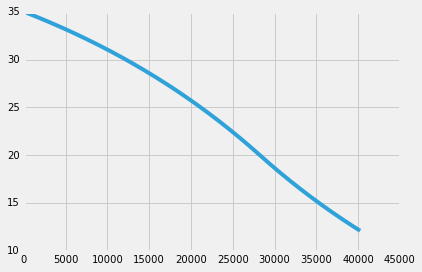

In [186]:
with plt.style.context('fivethirtyeight'):
    plt.plot(data_df[0], data_df[1])
    
plt.show()